In [12]:
import os
from os import path
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.transforms import ToTensor, ToPILImage, Lambda
import matplotlib.pyplot as plt
import math
import autolens as al

from PIL import Image

import numpy as np
import pandas as pd
from torchvision.io import read_image

In [13]:
class CosmosimImageDataset(Dataset):
    def __init__(self, root, annotations_filename='labels.csv', img_dir='images', train=True, all=False, transform=None, target_transform=None):
        df = pd.read_csv('{0}/{1}'.format(root.rstrip('/'), annotations_filename.lstrip('/')))
        if all:
            self.img_labels = df
        elif train:
            self.img_labels = df.head(math.floor(0.8 * len(df)))
        else:
            self.img_labels = df.tail(len(df) - math.floor(0.8 * len(df)))
        self.img_dir = '{0}/{1}'.format(root.rstrip('/'), img_dir.lstrip('/'))
        self.transform = transform
        self.target_transform = target_transform
        self.classes = list(self.img_labels.iloc[: , 1:].columns)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        labels = self.img_labels.iloc[idx, 1:]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels = self.target_transform(labels)
        return image.float(), labels.float()

In [14]:
def train_loop(dataloader, model, loss_fn, optimizer, device = None):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn, device = None):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test Error:\nAvg loss: {test_loss:>8f} \n")

In [15]:
root = "__local/data/Cosmosim/12"
transform = transforms.Compose([
    transforms.Resize(256, antialias=None),
    transforms.CenterCrop(224),
    transforms.ToPILImage(),
    transforms.ToTensor()
])

training_data = CosmosimImageDataset(
    root=root,
    train=True,
    transform=transform,
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)

test_data = CosmosimImageDataset(
    root=root,
    train=False,
    transform=transform,
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [16]:
training_data.img_labels

,name,r_ein,rdsf_l,x_l,y_l,ellx_l,elly_l,rdsf_s,r_eff_s,x_s,y_s,ellx_s,elly_s,int_s,si_s
0,xvexon.png,1.757431,0.247914,0.178845,0.092653,0.147317,0.388336,0.673459,0.542363,0.087555,0.200957,-0.083674,0.088614,1.904192,1.168557
1,joscdk.png,1.324986,0.367626,0.304225,0.436069,-0.103861,0.008714,0.861212,0.926125,0.474393,1.558200,0.066196,-0.045729,3.307833,2.555498
2,oioh8g.png,0.808125,0.230504,0.271197,-0.272668,0.353278,-0.346103,0.820123,0.840621,0.670787,-0.118396,-0.036379,-0.031485,1.250994,4.490823
3,l0t99c.png,1.663046,0.310735,0.049389,0.044383,0.193997,0.311871,0.893672,0.833320,-0.074285,-1.069417,-0.058374,-0.045233,0.599119,3.706767
4,m250p1.png,1.940759,0.202597,0.387351,0.386114,-0.220908,-0.313493,0.627548,0.902994,1.490205,1.175030,0.078978,-0.051351,2.102025,4.935156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,t6xzko.png,1.970479,0.292054,-0.287658,0.078148,0.236806,0.074162,1.164351,0.154261,-2.078288,0.306439,-0.036132,0.088983,1.283077,2.292917
79996,eirlov.png,1.692168,0.161914,-0.028109,0.177678,-0.191728,0.380567,0.637672,0.257046,0.887119,1.347501,-0.047862,0.060089,2.733816,4.549542
79997,buot1a.png,1.048528,0.372295,-0.176742,-0.064132,-0.362562,-0.386124,0.805240,0.207646,-0.123821,0.148015,0.024455,0.091449,1.163704,2.321275
79998,1jl36e.png,1.340779,0.368013,-0.474035,-0.434625,-0.195487,-0.246031,0.500974,0.141981,-0.371204,0.044136,0.057920,-0.075593,3.186491,1.067308


In [17]:
test_data.img_labels

,name,r_ein,rdsf_l,x_l,y_l,ellx_l,elly_l,rdsf_s,r_eff_s,x_s,y_s,ellx_s,elly_s,int_s,si_s
80000,1ljdjf.png,1.519850,0.374369,-0.306479,0.408289,0.142176,0.164211,0.687599,0.805523,-1.115735,0.855820,-0.076328,0.034552,2.450238,1.476786
80001,6iwyay.png,1.646404,0.215741,-0.418893,-0.479017,-0.316365,0.285009,0.884305,0.436153,-1.149674,-1.594595,-0.082092,0.046480,1.334906,2.245153
80002,9eqbdm.png,1.906949,0.283675,-0.074848,0.276087,0.054937,0.174425,0.644079,0.148458,-0.721957,-0.030222,-0.048297,-0.030050,0.643774,4.084527
80003,39qten.png,1.078951,0.135534,0.438610,-0.253552,-0.352750,-0.294195,0.912720,0.990887,0.894975,-0.594252,0.045003,-0.004798,1.155141,4.967645
80004,xc69q0.png,1.241416,0.341073,-0.069767,0.475884,-0.355482,-0.308539,0.998782,0.855902,0.099577,-0.039592,0.082479,-0.060292,2.864373,2.843276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,l1jvxm.png,1.106723,0.283285,-0.463132,0.325781,0.041264,-0.348514,0.670424,0.917859,0.075814,0.338261,0.021310,-0.095257,2.365978,3.306525
99996,6ol52f.png,1.124322,0.275130,0.261815,0.191286,0.197830,-0.011790,0.862692,0.690299,0.179197,0.226595,-0.047229,0.091301,2.892555,2.422589
99997,etcqft.png,1.500760,0.342927,-0.081247,-0.459553,-0.064689,-0.006367,0.606646,0.874671,-0.435275,0.550056,0.055740,0.078786,3.862508,3.748529
99998,quwa2a.png,0.939839,0.291957,-0.123628,-0.462988,0.192649,0.183946,0.579791,0.807370,-0.161614,0.318446,-0.025367,0.074680,0.111248,1.110727


In [18]:
training_data.classes

['r_ein',
 'rdsf_l',
 'x_l',
 'y_l',
 'ellx_l',
 'elly_l',
 'rdsf_s',
 'r_eff_s',
 'x_s',
 'y_s',
 'ellx_s',
 'elly_s',
 'int_s',
 'si_s']

In [19]:
labels_map = training_data.img_labels.r_ein
labels_map

0        1.757431
1        1.324986
2        0.808125
3        1.663046
4        1.940759
           ...   
79995    1.970479
79996    1.692168
79997    1.048528
79998    1.340779
79999    1.829699
Name: r_ein, Length: 80000, dtype: float64

In [20]:
idx = 0
img, label = training_data[idx]
print(label)

tensor([ 1.7574,  0.2479,  0.1788,  0.0927,  0.1473,  0.3883,  0.6735,  0.5424,
         0.0876,  0.2010, -0.0837,  0.0886,  1.9042,  1.1686])


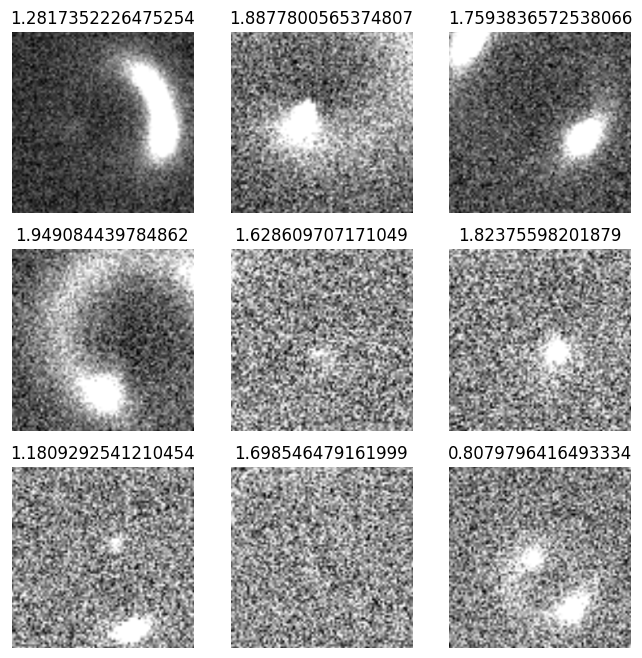

In [21]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[sample_idx])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Feature batch shape: torch.Size([64, 1, 224, 224])
Labels batch shape: torch.Size([64, 14])


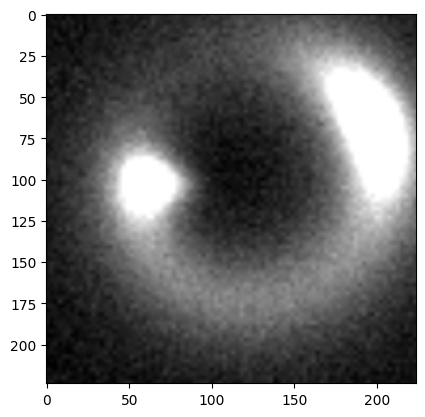

Label: tensor([ 1.4083,  0.3777,  0.1418, -0.2537, -0.1520,  0.0559,  1.1037,  0.7395,
         0.2498,  0.4072, -0.0251,  0.0434,  3.7277,  2.2725])


In [22]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [13]:
model = models.alexnet(weights='IMAGENET1K_V1')
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [14]:
model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
model.classifier[6] = nn.Linear(4096, len(training_data.classes))

In [15]:
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [16]:
loss_fn = nn.MSELoss()
learning_rate = 1e-3
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 15

In [17]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimiser, device)
    test_loop(test_dataloader, model, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 1.311081  [   64/80000]
loss: 0.240684  [ 6464/80000]
loss: 0.257922  [12864/80000]
loss: 0.264559  [19264/80000]
loss: 0.244279  [25664/80000]
loss: 0.221038  [32064/80000]
loss: 0.232349  [38464/80000]
loss: 0.239336  [44864/80000]
loss: 0.181496  [51264/80000]
loss: 0.218571  [57664/80000]
loss: 0.202975  [64064/80000]
loss: 0.168191  [70464/80000]
loss: 0.190889  [76864/80000]
Test Error:
Avg loss: 0.172658 

Epoch 2
-------------------------------
loss: 0.184003  [   64/80000]
loss: 0.176111  [ 6464/80000]
loss: 0.176571  [12864/80000]
loss: 0.155466  [19264/80000]
loss: 0.159462  [25664/80000]
loss: 0.153545  [32064/80000]
loss: 0.155630  [38464/80000]
loss: 0.181091  [44864/80000]
loss: 0.127436  [51264/80000]
loss: 0.151997  [57664/80000]
loss: 0.152962  [64064/80000]
loss: 0.148725  [70464/80000]
loss: 0.160473  [76864/80000]
Test Error:
Avg loss: 0.140202 

Epoch 3
-------------------------------
loss: 0.135335  [   64/80000]
loss

In [18]:
torch.save(model.state_dict(), '__local/models/model_alexnet_caustics_2.pth')

### Evaluation

In [19]:
root = "__local/data/Cosmosim/test_slacs_5"
transform = transforms.Compose([
    transforms.Resize(256, antialias=None),
    transforms.CenterCrop(224),
    transforms.ToPILImage(),
    transforms.ToTensor()
])
test_data = CosmosimImageDataset(
    root=root,
    img_dir="images",
    all=True,
    transform=transform,
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [20]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

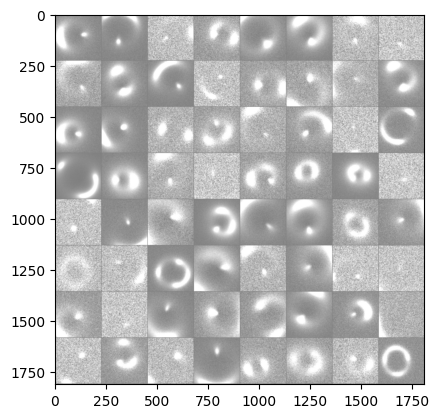

In [21]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [22]:
model = models.alexnet(weights='IMAGENET1K_V1')
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
model.classifier[6] = nn.Linear(4096, len(training_data.classes))

In [24]:
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [25]:
model_path = '__local/models/model_alexnet_caustics.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [26]:
def evaluate(dataloader, model, loss_fn, device = 'cpu'):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    preds = torch.empty((0,len(training_data.classes)))
    reals = torch.empty((0,len(training_data.classes)))
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            preds = torch.cat((preds, pred))
            reals = torch.cat((reals, y))

    return pd.DataFrame(preds), pd.DataFrame(reals)

In [27]:
loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
preds, reals = evaluate(test_dataloader, model, loss_fn)

In [29]:
pd.DataFrame({'pred': preds.iloc[5], 'real': reals.iloc[1]})

,pred,real
0,1.691496,1.852910
1,0.265121,0.257356
2,0.276184,-0.212267
3,-0.454285,-0.069632
4,0.111584,0.296021
5,0.178676,0.100249
6,0.793872,0.913136
7,0.375458,0.893233
8,-0.706066,-0.018916
9,0.346487,-1.093580


In [30]:
preds

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.891430,0.260983,0.059167,-0.248185,0.129987,0.182348,0.834251,0.162165,0.086644,0.084081,-0.009428,-0.009544,2.222669,2.962545
1,1.763757,0.261456,-0.245097,-0.073370,0.350698,0.005323,0.811644,0.911178,0.028305,-1.055260,-0.006278,-0.006106,3.246753,3.545292
2,1.377701,0.271285,0.235260,0.308627,-0.069239,-0.002567,0.797941,0.818567,-0.761105,0.384652,0.023294,-0.004753,1.835238,2.354927
3,1.632818,0.244950,0.136505,0.228066,-0.220046,-0.187116,0.833553,0.407019,0.062136,0.244573,-0.009158,-0.006576,1.545062,3.505608
4,1.256645,0.240594,0.308671,-0.406703,-0.301960,-0.161259,0.821402,0.510726,0.252520,-0.827994,-0.008921,-0.001871,0.643522,3.211080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.691780,0.292513,-0.236631,0.293697,0.083188,0.014485,0.821935,0.749233,-1.166689,-0.400515,0.008191,-0.014832,1.635773,2.158083
996,1.881651,0.234641,-0.020200,-0.042920,-0.138301,0.073116,0.838415,0.329899,0.117551,-0.937516,-0.011307,-0.028380,1.121816,2.543678
997,1.652087,0.255235,-0.180385,0.272854,-0.117732,-0.033557,0.775643,0.730345,0.352900,1.103722,0.024303,-0.039715,2.334787,2.552428
998,1.002261,0.247129,-0.288226,-0.528394,-0.099654,0.219673,0.788638,0.808101,-0.087272,0.252183,0.031337,-0.032847,1.588188,2.689955


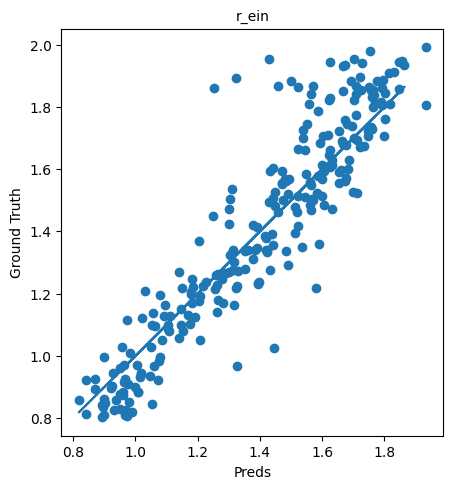

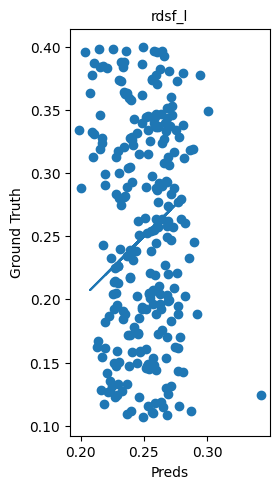

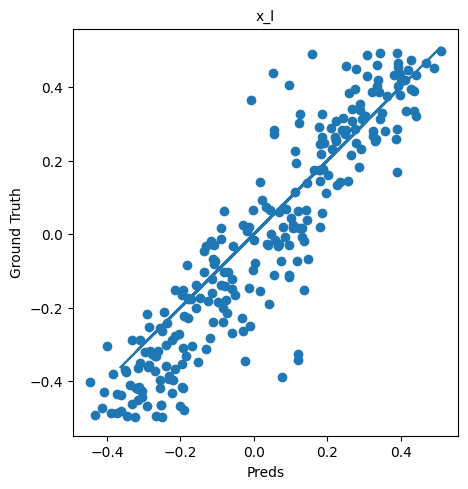

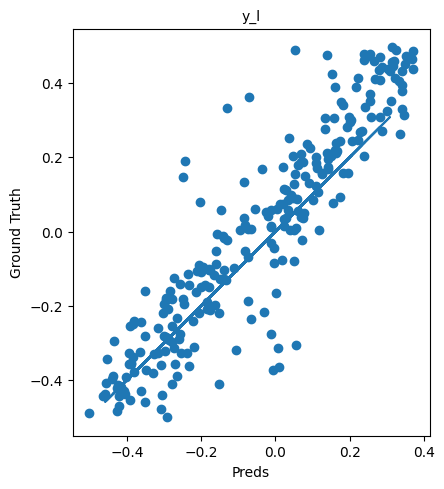

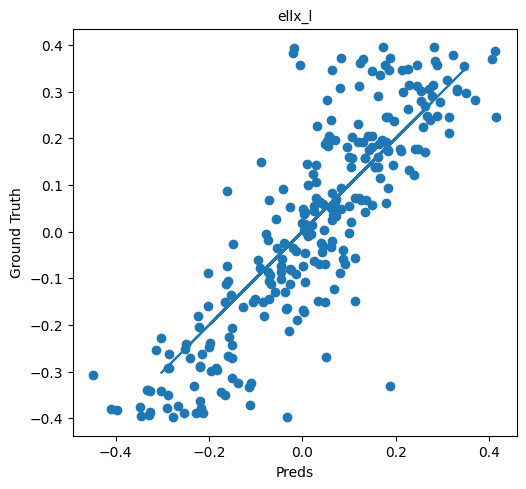

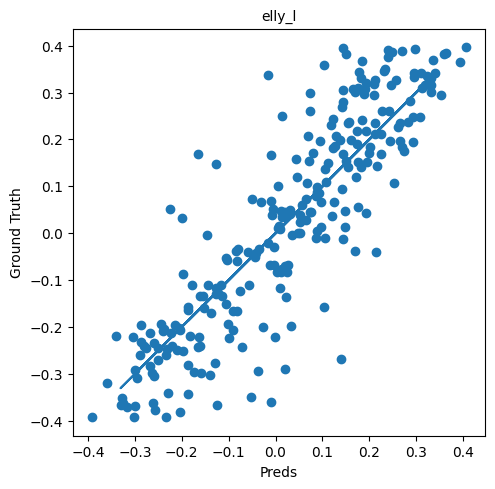

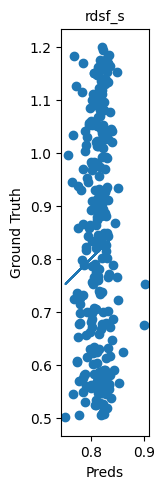

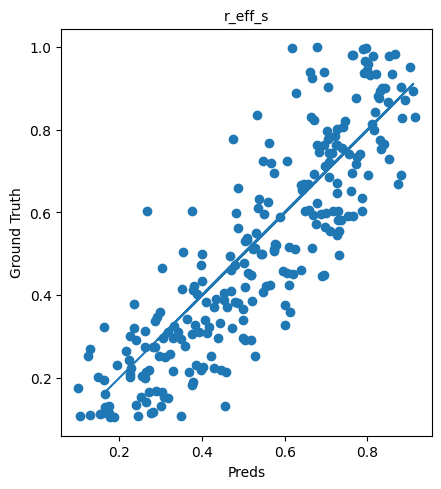

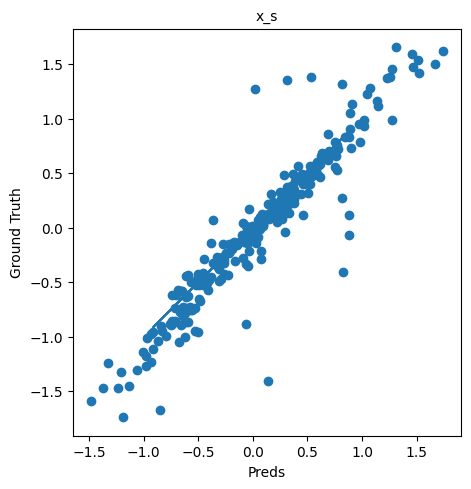

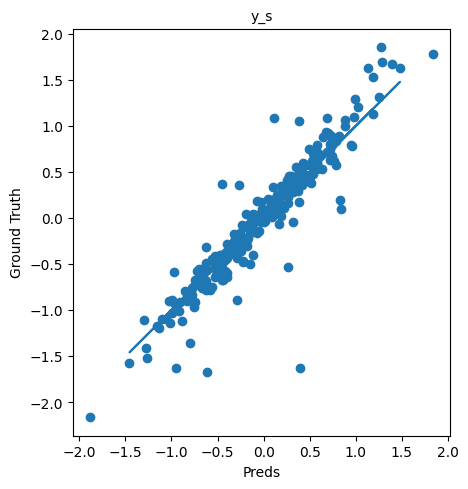

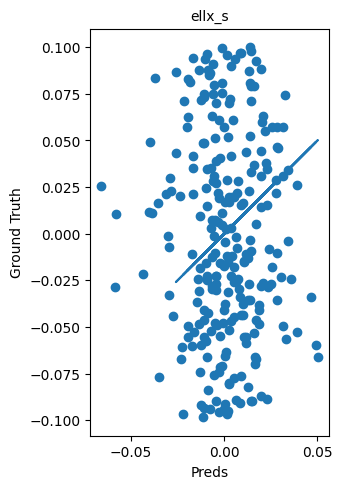

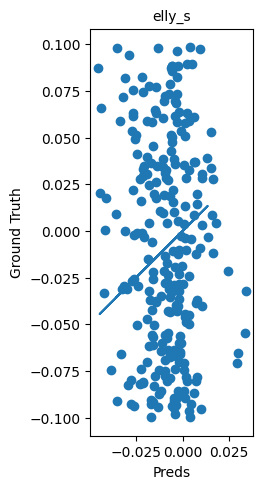

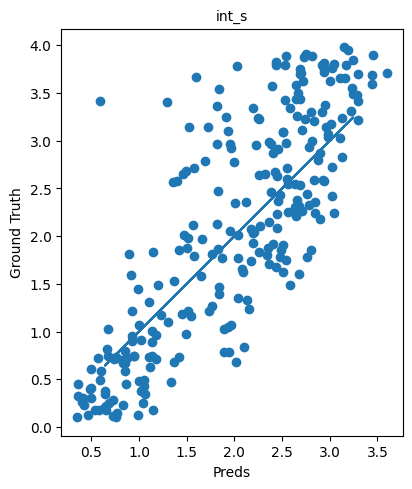

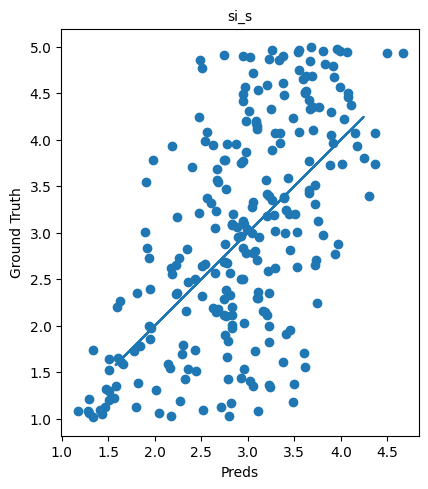

In [31]:
import matplotlib.pyplot as plt
import numpy as np

figs_path = '__local/reports/figures'

for i in range(14):
    fig, ax = plt.subplots()
    i=i
    x = preds[i][:32]
    y = reals[i][:32]
    a, b = np.polyfit(x, x, 1)
    
    ax.scatter(preds[i][:256], reals[i][:256])
    ax.plot(x, a*x+b)
    
    # ax.set_xlim(1.1, 1.7)
    # ax.set_ylim(1.1, 1.7)
    ax.set_aspect('equal', 'box')
    ax.set_title(training_data.classes[i], fontsize=10)
    
    fig.tight_layout()
    
    plt.xlabel("Preds")
    plt.ylabel("Ground Truth")
    plt.savefig(path.join(figs_path, '{}.png'.format(training_data.classes[i])))

# plt.show()

In [32]:
root = "__local/data/Cosmosim/slacs/selected"
test_data = CosmosimImageDataset(
    root=root,
    img_dir="images",
    all=True,
    transform=transform,
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

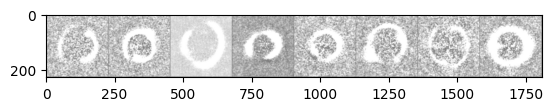

In [33]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [34]:
def simulate(grid, lens_galaxy, source_galaxy, simulator, shape=100):

    tracer = al.Tracer.from_galaxies(
        galaxies=[lens_galaxy, source_galaxy]
    )

    dataset = simulator.via_tracer_from(tracer=tracer, grid=grid)

    data = np.array(dataset.data)

    # Choose the lower and upper percentiles for normalization
    lower_percentile = 1
    upper_percentile = 95

    # Calculate the lower and upper limits for normalization
    lower_limit = np.percentile(data, lower_percentile)
    upper_limit = np.percentile(data, upper_percentile)

    # Clip and normalize the data to the 0-255 range
    normalized_data = np.clip(data, lower_limit, upper_limit)
    normalized_data = ((normalized_data - lower_limit) / (upper_limit - lower_limit) * 255).astype(np.uint8)

    normalized_data = normalized_data.reshape(shape,shape)

    im = Image.fromarray(normalized_data).convert('L')
    # im = im.resize((400,400))

    return im

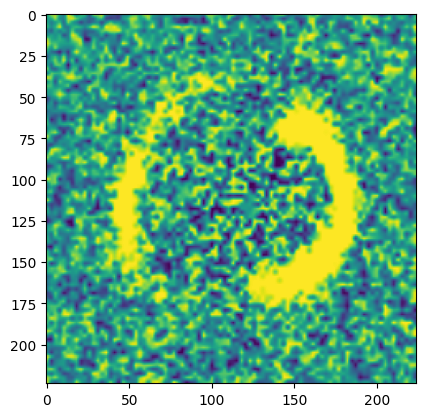

tensor([ 1.4195,  0.2466,  0.1742,  0.1866,  0.0764, -0.1403,  0.8438,  0.1840,
         0.2577, -0.0149, -0.0185,  0.0152,  2.1924,  2.7622],
       grad_fn=<SelectBackward0>)
['r_ein', 'rdsf_l', 'x_l', 'y_l', 'ellx_l', 'ellx_y', 'rdsf_s', 'r_eff_s', 'x_s', 'y_s', 'ellx_s', 'elly_s', 'int_s', 'si_s']


In [35]:
outputs = model(images)
i = 0
imshow(images[i])
print(outputs[i])
print(test_data.classes)

In [36]:
def model_paramaters(parameters):
    shape = 100
    scale = 0.05
    
    grid = al.Grid2D.uniform(
        shape_native=(shape, shape), 
        pixel_scales=scale
    )
    
    psf = al.Kernel2D.from_gaussian(
        shape_native=(21, 21), 
        sigma=0.1, 
        pixel_scales=grid.pixel_scales
    )
    
    simulator = al.SimulatorImaging(
        exposure_time=720.0, 
        psf=psf, 
        background_sky_level=800, 
        add_poisson_noise=True
    )
    
    lens = al.Galaxy(
        redshift=parameters.rdsf_l,
        mass=al.mp.Isothermal(
            centre=(parameters.x_l, parameters.y_l), einstein_radius=parameters.r_ein, ell_comps=(parameters.ellx_l, parameters.elly_l)
        ),
    )
    
    source = al.Galaxy(
        redshift=parameters.rdsf_s,
        bulge=al.lp.Sersic(
            centre=(parameters.x_s,parameters.y_s),
            ell_comps=(parameters.ellx_s, parameters.elly_s),
            intensity=parameters.int_s,
            effective_radius=parameters.r_eff_s,
            sersic_index=parameters.si_s,
        ),
    )

    return simulate(grid, lens, source, simulator, shape)

In [37]:
outputs = model(images)
outputs = outputs.detach().numpy()
parameters = pd.DataFrame(outputs, columns=training_data.classes)

In [38]:
parameters

,r_ein,rdsf_l,x_l,y_l,ellx_l,elly_l,rdsf_s,r_eff_s,x_s,y_s,ellx_s,elly_s,int_s,si_s
0,1.419529,0.246579,0.174223,0.186643,0.076446,-0.140266,0.843767,0.184004,0.257747,-0.014896,-0.018512,0.015198,2.192388,2.762237
1,1.255379,0.240049,-0.088606,-0.023041,-0.184719,-0.090495,0.833871,0.014416,0.089716,0.062788,-0.082143,0.024442,3.150002,1.632643
2,1.781453,0.238885,0.044314,0.000637,-0.032294,-0.061409,0.851571,0.908546,0.350808,0.149053,0.010330,-0.026232,1.174905,1.361070
3,1.163203,0.238366,-0.126782,0.170161,-0.290159,-0.168946,0.828201,0.185475,0.030192,-0.106689,-0.054501,0.020840,3.444677,2.950926
4,1.509341,0.243172,-0.028277,-0.026347,0.036007,0.072605,0.815672,0.286231,0.118672,-0.113490,0.003882,-0.009485,1.775244,2.641836
5,1.348219,0.245296,0.058097,0.151554,-0.140158,-0.133491,0.816881,0.195702,0.033835,-0.057645,-0.065196,0.022071,2.997630,2.361645
6,1.699291,0.258731,-0.062733,0.075545,0.018492,0.027594,0.832248,0.371096,-0.222767,-0.114691,-0.005081,0.002527,2.198664,2.037180
7,1.334832,0.260991,-0.017583,0.147194,0.103736,-0.223026,0.818418,0.229174,-0.105322,-0.191268,-0.086186,0.034497,3.140577,2.002850


In [39]:
output_images = []
reconstructed_path = "__local/data/Cosmosim/slacs/processed/reconstructed"

for i in range(len(parameters.index)):
    im = model_paramaters(parameters.iloc[i])
    output_images.append(im)
    im.save(path.join(reconstructed_path, '{}.png'.format(i)))

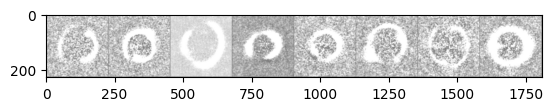

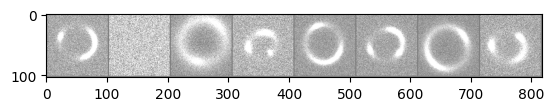

In [40]:
transform = transforms.Compose([transforms.ToTensor()])
out = [transform(x) for x in output_images]
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(out))

In [41]:
preds, reals = evaluate(test_dataloader, model, loss_fn)

In [42]:
pd.DataFrame({'pred': preds.iloc[5], 'real': reals.iloc[1]})

,pred,real
0,1.334832,1.040000
1,0.260991,0.280000
2,-0.017583,0.000000
3,0.147194,0.000000
4,0.103736,-0.019434
5,-0.223026,-0.030623
6,0.818418,0.982000
7,0.229174,1.390000
8,-0.105322,0.000000
9,-0.191268,0.000000


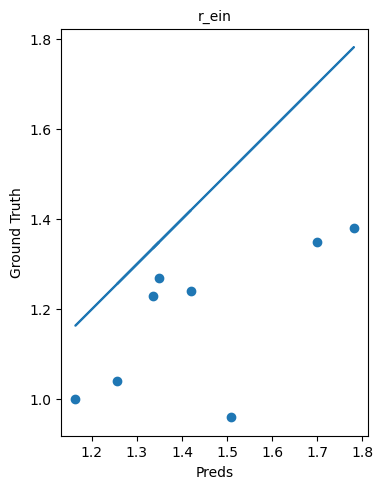

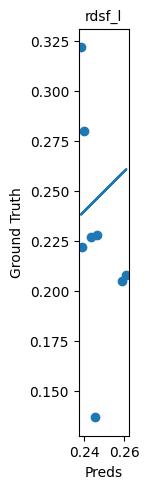

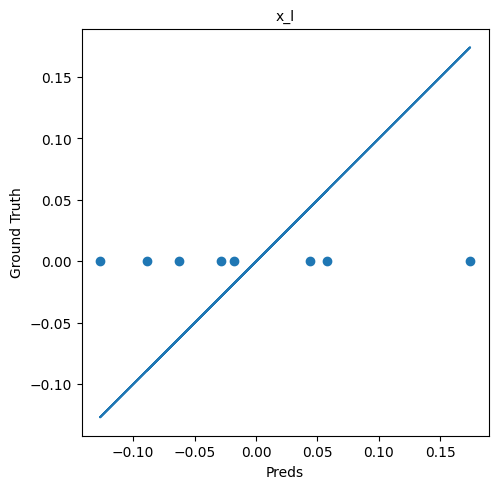

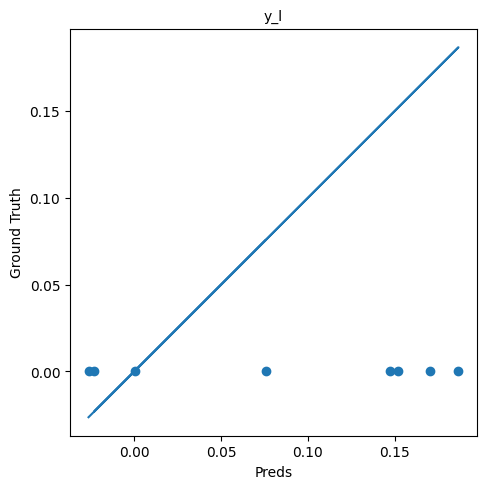

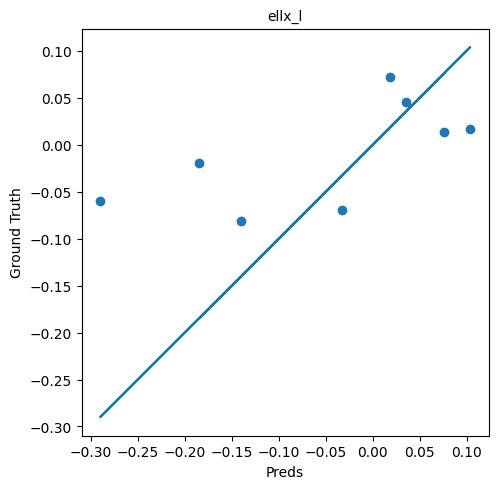

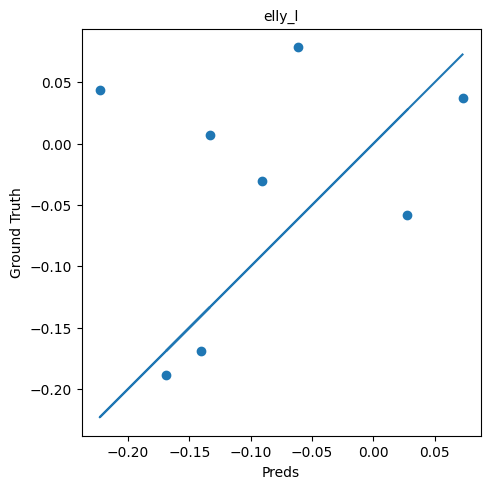

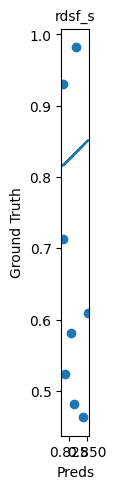

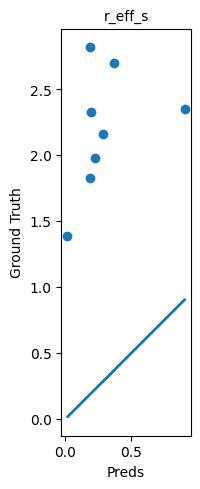

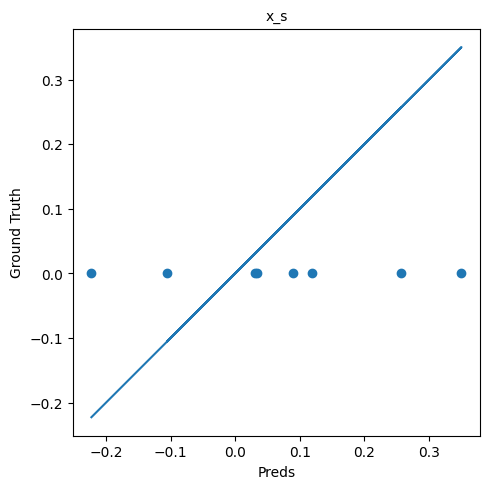

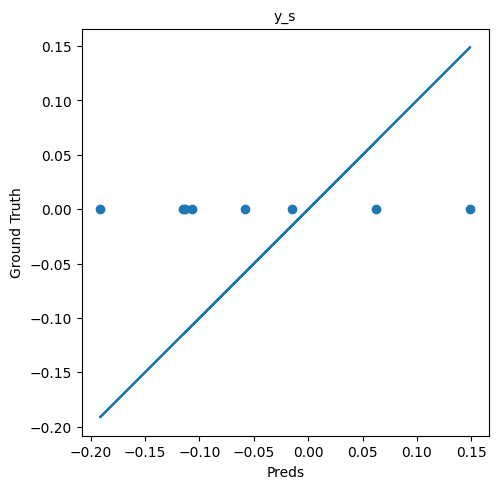

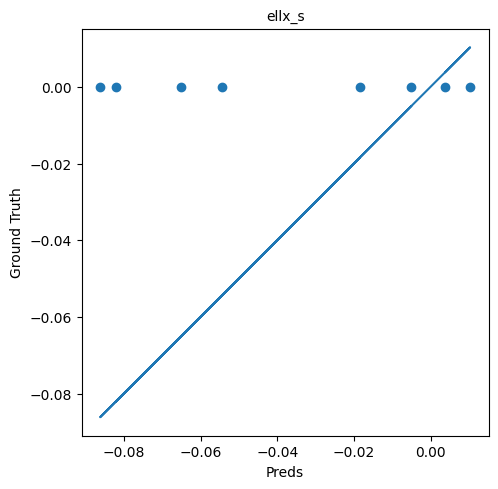

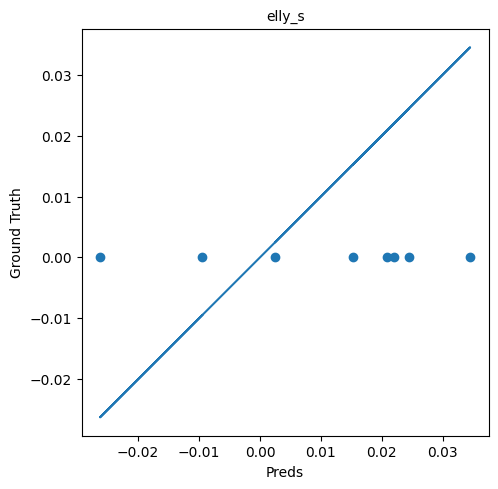

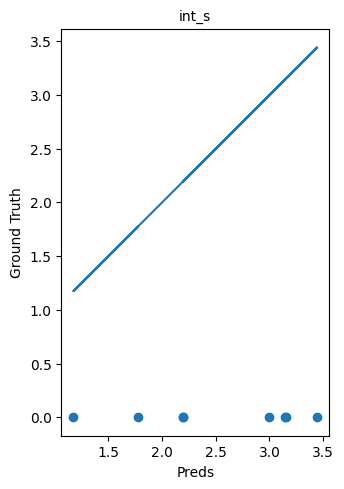

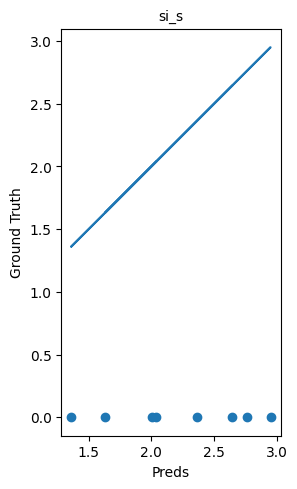

In [43]:
import matplotlib.pyplot as plt
import numpy as np

figs_path = '__local/reports/figures/real'

for i in range(14):
    fig, ax = plt.subplots()
    i=i
    x = preds[i][:8]
    y = reals[i][:8]
    a, b = np.polyfit(x, x, 1)
    
    ax.scatter(preds[i][:8], reals[i][:8])
    ax.plot(x, a*x+b)
    
    # ax.set_xlim(1.1, 1.7)
    # ax.set_ylim(1.1, 1.7)
    ax.set_aspect('equal', 'box')
    ax.set_title(training_data.classes[i], fontsize=10)
    
    fig.tight_layout()
    
    plt.xlabel("Preds")
    plt.ylabel("Ground Truth")
    plt.savefig(path.join(figs_path, '{}.png'.format(training_data.classes[i])))